<a href="https://colab.research.google.com/github/kconstable/market_predictions/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing for Deep Learning
## Import Libraries

In [64]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt 
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [50]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/market_data_full.pickle')

In [51]:
def scale_data(df,y='close',features=[]):
  """
  """

  # reverse the index such that dates are in chronological order
  df = df.iloc[::-1]

  # Subset features, get the y values
  df_y = df[y]
  df_X = df[features]

  # save the date index, then replace the date index with an integer index
  idx_date = df_X.index
  df_X.reset_index(drop=True,inplace=True)

  # convert to numpay arrays
  array_X = np.array(df_X)
  array_y = np.array(df_y).reshape(-1,1)

  # scale the input and outputs
  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(array_X)
  scaled_y = scaler.fit_transform(array_y)

  # print the output
  print("Data Scaling")
  print("--"*50)
  print(f"=> {len(features)} Features")
  print("=>",features)
  print(f"=> Input Dimensions:{scaled_X.shape}")
  print(f"=> Output Dimensions:{scaled_y.shape}")

  return scaled_y, scaled_X, idx_date

scaled_y,scaled_X, idx_date = scale_data(df,'close',['open','high','volume','low','BAR','OILK','VXZ','b-lower','b-upper','rsi','macd_signal'])


Data Scaling
----------------------------------------------------------------------------------------------------
=> 11 Features
=> ['open', 'high', 'volume', 'low', 'BAR', 'OILK', 'VXZ', 'b-lower', 'b-upper', 'rsi', 'macd_signal']
=> Input Dimensions:(5494, 11)
=> Output Dimensions:(5494, 1)


In [58]:
# The number of time steps included in each training batch
# The number of time steps into the future the model will predict
batch_input_ts_steps = 50
batch_output_ts_steps = 10
train_pct = 0.8

idx_close = df.columns.get_loc("close")

# split into train, test
train_num = math.ceil(scaled_X.shape[0]*train_pct)

train = scaled_X[0:train_num,:]
test = scaled_X[train_num - batch_input_ts_steps:,:]
test.shape

# LSTM input format: [samples, time steps, features]
# https://www.relataly.com/time-series-forecasting-multi-step-regression-using-neural-networks-with-multiple-outputs-in-python/5800/
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, idx_close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(batch_input_ts_steps, batch_output_ts_steps, train)
x_test, y_test = partition_dataset(batch_input_ts_steps, batch_output_ts_steps, test)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(4336, 50, 11) (4336, 10)
(1088, 50, 11) (1088, 10)


In [72]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0.649718,0.649718,0.653390,0.665537,0.655085,0.653390,0.651412,0.646328,0.649718,0.639266
1,0.649718,0.653390,0.665537,0.655085,0.653390,0.651412,0.646328,0.649718,0.639266,0.618079
2,0.653390,0.665537,0.655085,0.653390,0.651412,0.646328,0.649718,0.639266,0.618079,0.614407
3,0.665537,0.655085,0.653390,0.651412,0.646328,0.649718,0.639266,0.618079,0.614407,0.614407
4,0.655085,0.653390,0.651412,0.646328,0.649718,0.639266,0.618079,0.614407,0.614407,0.621469
...,...,...,...,...,...,...,...,...,...,...
4331,0.723164,0.724294,0.730226,0.725989,0.726554,0.726836,0.727684,0.731638,0.733054,0.720621
4332,0.724294,0.730226,0.725989,0.726554,0.726836,0.727684,0.731638,0.733054,0.720621,0.721186
4333,0.730226,0.725989,0.726554,0.726836,0.727684,0.731638,0.733054,0.720621,0.721186,0.721469
4334,0.725989,0.726554,0.726836,0.727684,0.731638,0.733054,0.720621,0.721186,0.721469,0.727401


<function matplotlib.pyplot.show>

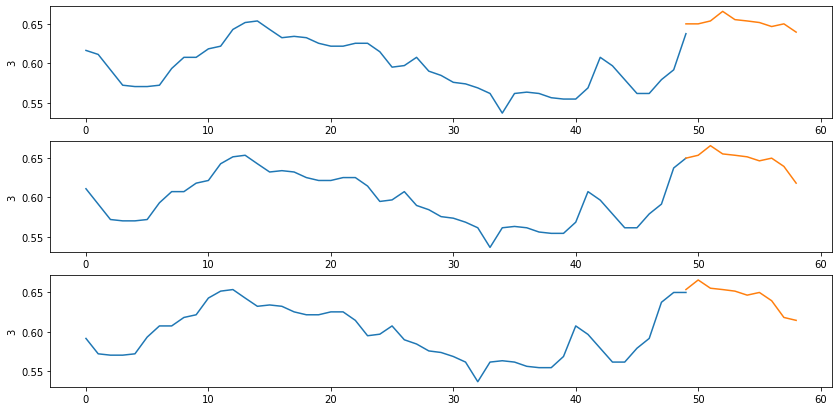

In [67]:
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(14, 7))
for i in range(nrows):
    sns.lineplot(y = pd.DataFrame(x_train[i])[idx_close], x = range(batch_input_ts_steps), ax = ax[i])
    sns.lineplot(y = y_train[i], x = range(batch_input_ts_steps -1, batch_input_ts_steps + batch_output_ts_steps - 1), ax = ax[i])
plt.show